In [19]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import normpath

sns.set_theme(font_scale=1, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)
%matplotlib inline
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [20]:
%load_ext autoreload
%autoreload 2

from tools import cleaning, plotting, language, utils

plt.rcParams.update(plotting.MPL_DEFAULTS)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

# Overview of Dataset

In [21]:
df = pd.read_csv(normpath("data/crowdflower_tweets.csv"))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

Looks like one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing this dataset. I'm going to rename those before I do anything else.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [23]:
# Assign new column names
df.columns = ["tweet_text", "object_of_emotion", "emotion"]
df.head()

,tweet_text,object_of_emotion,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [24]:
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative emotion
iPad or iPhone App,Positive emotion
iPad,No emotion toward brand or product
Google,I can't tell
Android,
Apple,
Android App,
Other Google product or service,
Other Apple product or service,


<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [25]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [26]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "None",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative
iOS App,Positive
iPad,None
Google,Uncertain
Android,
Apple,
Android App,
Other Google Product,
Other Apple Product,


<IPython.core.display.Javascript object>

## Missing Values and Duplicates

I've see that 'emotion' has a 'None' category, but tweets which don't express an emotion towards a brand comprise a genuine category. Those are not missing values.

According to the table below, there are missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'None' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

Furthermore, there's one row with no tweet text and $22$ duplicates which need to be dropped.

In [27]:
cleaning.info(df)

,nan,nan_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5802,63.81,9,0.10,22,0.24
tweet_text,1,0.01,9065,99.69,22,0.24
emotion,0,0.00,4,0.04,22,0.24


<IPython.core.display.Javascript object>

In [28]:
# Slice out the non-null tweets
df = df.loc[~df.tweet_text.isna()]
cleaning.info(df)

,nan,nan_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5801,63.8,9,0.10,22,0.24
tweet_text,0,0.0,9065,99.70,22,0.24
emotion,0,0.0,4,0.04,22,0.24


<IPython.core.display.Javascript object>

Looks like I was roughly (though not entirely) correct that the NaN values correspond to the 'None' Category.

In [29]:
null_rows = cleaning.nan_rows(df)
null_rows.sample(10, random_state=55)

,tweet_text,object_of_emotion,emotion
5840,RT @mention Google launching check in service ...,NaN,Positive
1904,@mention after a few days of #sxsw you still t...,NaN,None
3893,#sxsw - Missed Marissa Mayer @mention yesterda...,NaN,None
6866,RT @mention Want a taste of the artists at thi...,NaN,None
4748,iPad 2 Contest- Join actsofsharing.com and sta...,NaN,None
5242,RT @mention #LolShow Podcast w/ @mention @ment...,NaN,None
3687,a #sxsw find... love @mention #sxswi {link} #i...,NaN,None
5392,RT @mention Anna's Social Media Picks of the W...,NaN,None
2602,Or all the above? RT @mention setting up temp ...,NaN,None
5025,RT @mention,NaN,None


<IPython.core.display.Javascript object>

In [30]:
emo_no_obj = null_rows.loc[null_rows.emotion != "None"]
display(emo_no_obj.head(), emo_no_obj.shape)

,tweet_text,object_of_emotion,emotion
46,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...,NaN,Positive
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative
90,Thanks to @mention for publishing the news of ...,NaN,Uncertain
102,���@mention &quot;Apple has opened a pop-up st...,NaN,Uncertain


(504, 3)

<IPython.core.display.Javascript object>

In [31]:
# Create regex for finding each brand
re_apple = r"ipad\d?\s+app|ipad\d?|iphone\s+app|iphone|apple"
re_google = r"android\s+app|android|google"

# Find all brand/product name occurrences for each brand
findings = language.identify_brands(
    re_apple,
    re_google,
    docs=emo_no_obj["tweet_text"],
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

google         170
ipad           138
apple          108
iphone          86
ipad2           31
android         21
iphone app       9
ipad app         4
ipad1            1
android app      1
Name: brands, dtype: int64

569

<IPython.core.display.Javascript object>

In [32]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = language.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

,original,extracted,score
4831,ipad2,iPad,89
5586,ipad1,iPad,89
5586,ipad2,iPad,89
5401,ipad2,iPad,89
5240,ipad2,iPad,89
...,...,...,...
3224,ipad,iPad,100
3265,google,Google,100
3267,ipad,iPad,100
3145,google,Google,100


<IPython.core.display.Javascript object>

In [33]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="extracted",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.extracted.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=2389)

,tweet_text,object_of_emotion,emotion
417,Shipments daily - follow @mention #AppleATXdt ...,iPad,Negative
6133,RT @mention Interesting --&gt;&gt; RT @mention...,Google,Positive
3267,Food4Thought...juxtaposed on my iPad #SXSW is ...,iPad,Positive
3551,@mention I heard you got the first IPad 2 at @...,iPad,Positive
559,GSD&amp;M Google #sxsw party with @mention is ...,Google,Positive
2116,iPhone crashed in front of #sxsw Apple pop-up....,iPhone,Uncertain
2447,Near Field Communication already here on andro...,Android,Positive
2334,Saw a bunch of security guards playing with iP...,iPad,Uncertain
8695,Bad news update: the pop-up Apple Store is out...,iPad,Negative
4399,Sound of My Voice was shot exploiting Apple &a...,Apple,Positive


<IPython.core.display.Javascript object>

In [160]:
df.loc[(df.emotion == "None") & df.object_of_emotion.notnull()]

,tweet_text,object_of_emotion,emotion
63,#Smile RT @mention I think Apple's &quot;pop-u...,Apple,None
265,The #SXSW Apple &quot;pop-up&quot; store was n...,Apple,None
317,I arrived at #sxsw and my @mention issue hasn'...,iOS App,None
558,haha. the google &quot;Party like it's 1986&qu...,Google,None
588,Diller on Google TV: &quot;The first product w...,Other Google Product,None
...,...,...,...
8691,Apple popup store! #SXSW @mention Apple Store...,Apple,None
8722,"my wife just tried to call my ATT iphone, only...",iPhone,None
8849,We can't wait to give an iPad to someone at #s...,iPad,None
8902,@mention Which is to say iPad is going to be u...,iPad,None


<IPython.core.display.Javascript object>

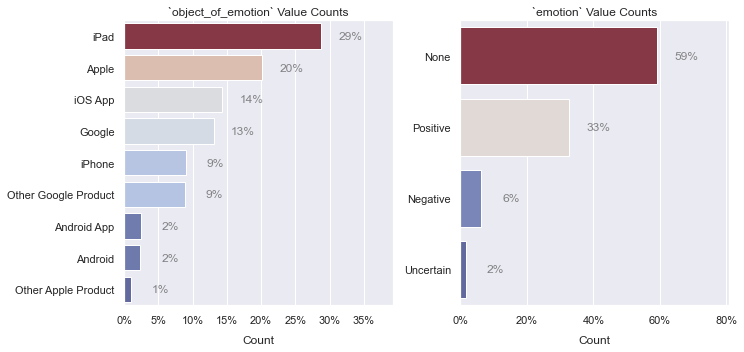

<IPython.core.display.Javascript object>

In [9]:
fig = plotting.multi_countplot(data=df.select_dtypes("category"), normalize=1)

In [44]:
cleaning.dup_rows(df).sort_values("tweet_text")

,tweet_text,object_of_emotion,emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
776,Google to Launch Major New Social Network Call...,NaN,None
8483,I just noticed DST is coming this weekend. How...,iPhone,Negative
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,None
8747,Need to buy an iPad2 while I'm in Austin at #s...,iPad,Positive
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iOS App,Positive
5884,RT @mention Google to Launch Major New Social ...,NaN,None
5882,RT @mention Google to Launch Major New Social ...,NaN,None


<IPython.core.display.Javascript object>

In [53]:
retweet_mask = df.tweet_text.str.startswith("RT")
df.loc[retweet_mask].select_dtypes("category").value_counts()

object_of_emotion     emotion  
iPad                  Positive     124
Apple                 Positive     101
iOS App               Positive      99
Google                Positive      78
Other Google Product  Positive      50
iPad                  Negative      30
iPhone                Positive      30
Google                Negative      16
Apple                 Negative      16
Other Google Product  Negative      11
Android               Positive      10
Android App           Positive       9
iOS App               Negative       8
iPhone                Negative       8
iPad                  None           5
Other Apple Product   Positive       4
Google                None           3
Other Google Product  None           1
iPad                  Uncertain      1
Apple                 None           1
iOS App               None           1
iPhone                None           1
dtype: int64

<IPython.core.display.Javascript object>

Well, it wouldn't be data science if the dataset made any sense.